In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

weather=pd.read_csv("../../MCI_30_Corrected.csv")
weather['DATE']= pd.to_datetime(weather['DATE'])
weather.set_index(["DATE"],inplace=True)
weather = weather.loc['2000-01-04':'2022-12-26']
weekly = weather.groupby(pd.Grouper(freq='7D')).mean()
DM=pd.read_csv("../../dm_Full.csv")
df_reverse_rows = DM.iloc[::-1]
test=df_reverse_rows.reset_index(drop=True)
test['Drought_Level'] = test[["None","D0","D1","D2","D3","D4"]].idxmax(axis=1)
test2=test[["ValidStart","Drought_Level"]].copy()
test2['ValidStart'] = pd.to_datetime(test2.ValidStart)
#test2['ValidStart'] = pd.to_datetime(test2.ValidStart, format='%Y/%m/%d')   
test2.set_index("ValidStart",inplace=True)
test3=test2.replace({'Drought_Level':{'None':'No','D0':'Yes','D1':'Yes','D2':'Yes','D3':'Yes','D4':'Yes'}})
weekly_DM=weekly.merge(test3, how='outer',left_index=True, right_index=True)
weekly_DM.reset_index(inplace=True)
weekly_DM

In [2]:
weekly_DM=pd.read_csv("../../weekly_DM.csv")

In [3]:
data=weekly_DM[["AWND","PRCP","SNOW","SNWD","TMAX","TMIN"]].copy()

# Scaling the data

In [4]:
scaler=StandardScaler()
data_scaled=pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

In [5]:
data_scaled.head()

,AWND,PRCP,SNOW,SNWD,TMAX,TMIN
0,0.483565,-0.698838,-0.281020,-0.234629,-1.042945,-1.152656
1,0.562650,-0.718034,-0.281020,-0.234629,-0.990180,-1.012231
2,-0.248861,-0.641252,0.719800,-0.026598,-1.246466,-1.511521
3,-0.312983,-0.506884,2.387833,1.845682,-2.007788,-1.651946
4,0.133027,-0.718034,-0.281020,0.389464,-1.133399,-1.347691


# Principal Component Analysis

In [6]:
#Defining the number of principal components to generate 
n=data_scaled.shape[1]

#Finding principal components for the data
pca = PCA(n_components=n, random_state=1) 

data_pca1 = pd.DataFrame(pca.fit_transform(data_scaled))

#The percentage of variance explained by each principal component
exp_var = pca.explained_variance_ratio_

Text(0, 0.5, 'Cumulative Explained Variance')

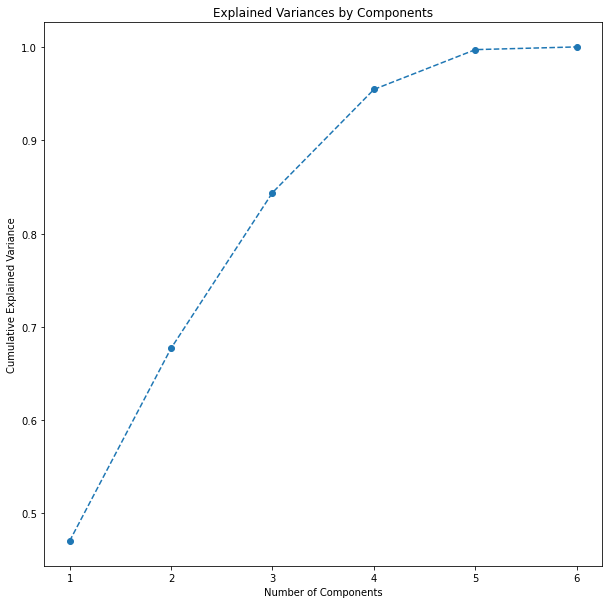

In [7]:
# visulaize the explained variance by individual components
plt.figure(figsize = (10,10))
plt.plot(range(1,7), exp_var.cumsum(), marker = 'o', linestyle = '--')
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

In [8]:
# find the least number of components that can explain more than 90% variance
sum = 0
for ix, i in enumerate(exp_var):
  sum = sum + i
  if(sum>0.90):
    print("Number of PCs that explain at least 90% variance: ", ix+1)
    break

Number of PCs that explain at least 90% variance:  4


In [9]:
pc_comps = ['PC1','PC2','PC3','PC4']
data_pca = pd.DataFrame(np.round(pca.components_[:4,:],2),index=pc_comps,columns=data_scaled.columns)
data_pca.T

,PC1,PC2,PC3,PC4
AWND,0.19,-0.45,0.65,0.58
PRCP,-0.18,0.36,0.76,-0.51
SNOW,0.43,0.50,0.05,0.23
SNWD,0.42,0.53,-0.02,0.24
TMAX,-0.54,0.24,-0.01,0.41
TMIN,-0.53,0.29,0.02,0.35


Text(0, 0.5, 'PC2')

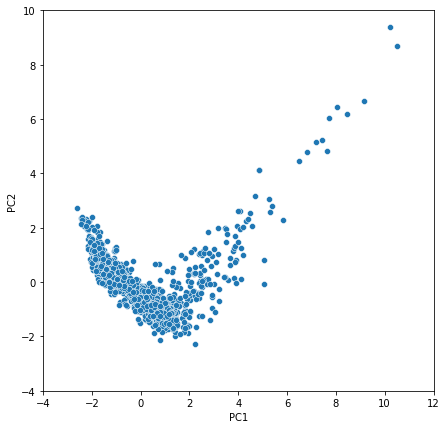

In [10]:
df_concat = pd.concat([data_pca1, data], axis=1)

plt.figure(figsize = (7,7))
#Create a scatter plot with x=0 and y=1 using df_concat dataframe
sns.scatterplot(data = df_concat, x=df_concat[0], y=df_concat[1])
plt.xlim(-4, 12)
plt.ylim(-4, 10)
plt.xlabel("PC1")
plt.ylabel("PC2")

Text(0, 0.5, 'PC2')

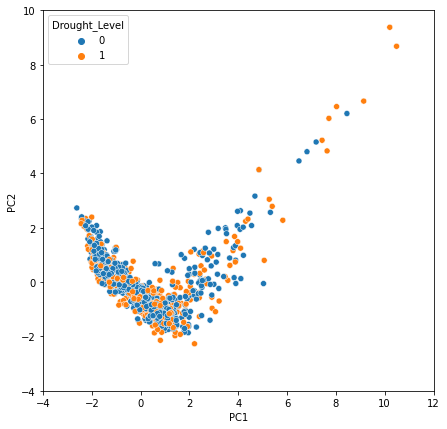

In [11]:
df_concat = pd.concat([data_pca1, weekly_DM], axis=1)

plt.figure(figsize = (7,7))
#Create a scatter plot with x=0 and y=1 using df_concat dataframe
sns.scatterplot(data = df_concat, x=df_concat[0], y=df_concat[1],hue ='Drought_Level')
plt.xlim(-4, 12)
plt.ylim(-4, 10)
plt.xlabel("PC1")
plt.ylabel("PC2")

# t-SNE

In [12]:
#Apply the TSNE algorithm
tsne = TSNE(n_components = 2)  

#Fit and transform tsne function on the scaled data
data_tsne = tsne.fit_transform(data_scaled)

In [13]:
data_tsne.shape

(1199, 2)

In [14]:
data_tsne = pd.DataFrame(data = data_tsne, columns = ['Component 1', 'Component 2'])

In [15]:
data_tsne.head()

,Component 1,Component 2
0,24.639673,-3.153774
1,23.182697,-3.694487
2,39.934792,0.880596
3,50.990929,-0.075310
4,30.586706,-1.352029


<AxesSubplot:xlabel='Component 1', ylabel='Component 2'>

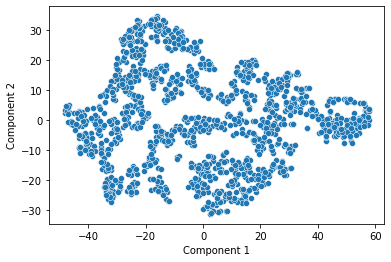

In [16]:
sns.scatterplot(x=data_tsne.iloc[:,0],y=data_tsne.iloc[:,1])

<AxesSubplot:xlabel='Component 1', ylabel='Component 2'>

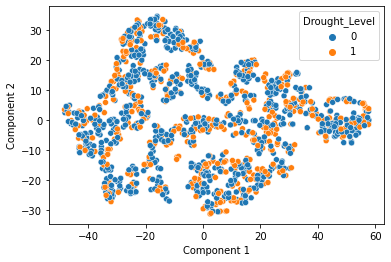

In [18]:
sns.scatterplot(x=data_tsne.iloc[:,0],y=data_tsne.iloc[:,1],hue=weekly_DM.Drought_Level)

In [43]:
# Lets assign points to the 3 different groups
def grouping(x):
    first_component = x['Component 1']
    second_component = x['Component 2']
    if (first_component> 0) and (second_component >0): 
        return 'group_1'
    if (first_component >-25 ) and (first_component < 10):
        return 'group_2'
    else: 
        return 'group_3'

In [44]:
data_tsne['groups'] = data_tsne.apply(grouping,axis=1)

<AxesSubplot:xlabel='Component 1', ylabel='Component 2'>

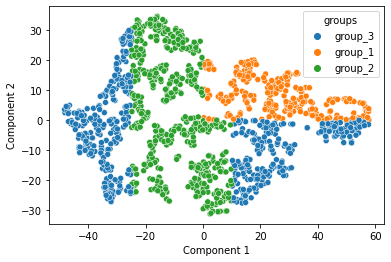

In [45]:
sns.scatterplot(x=data_tsne.iloc[:,0],y=data_tsne.iloc[:,1],hue=data_tsne.iloc[:,2])

In [46]:
data['groups'] = data_tsne['groups'] 

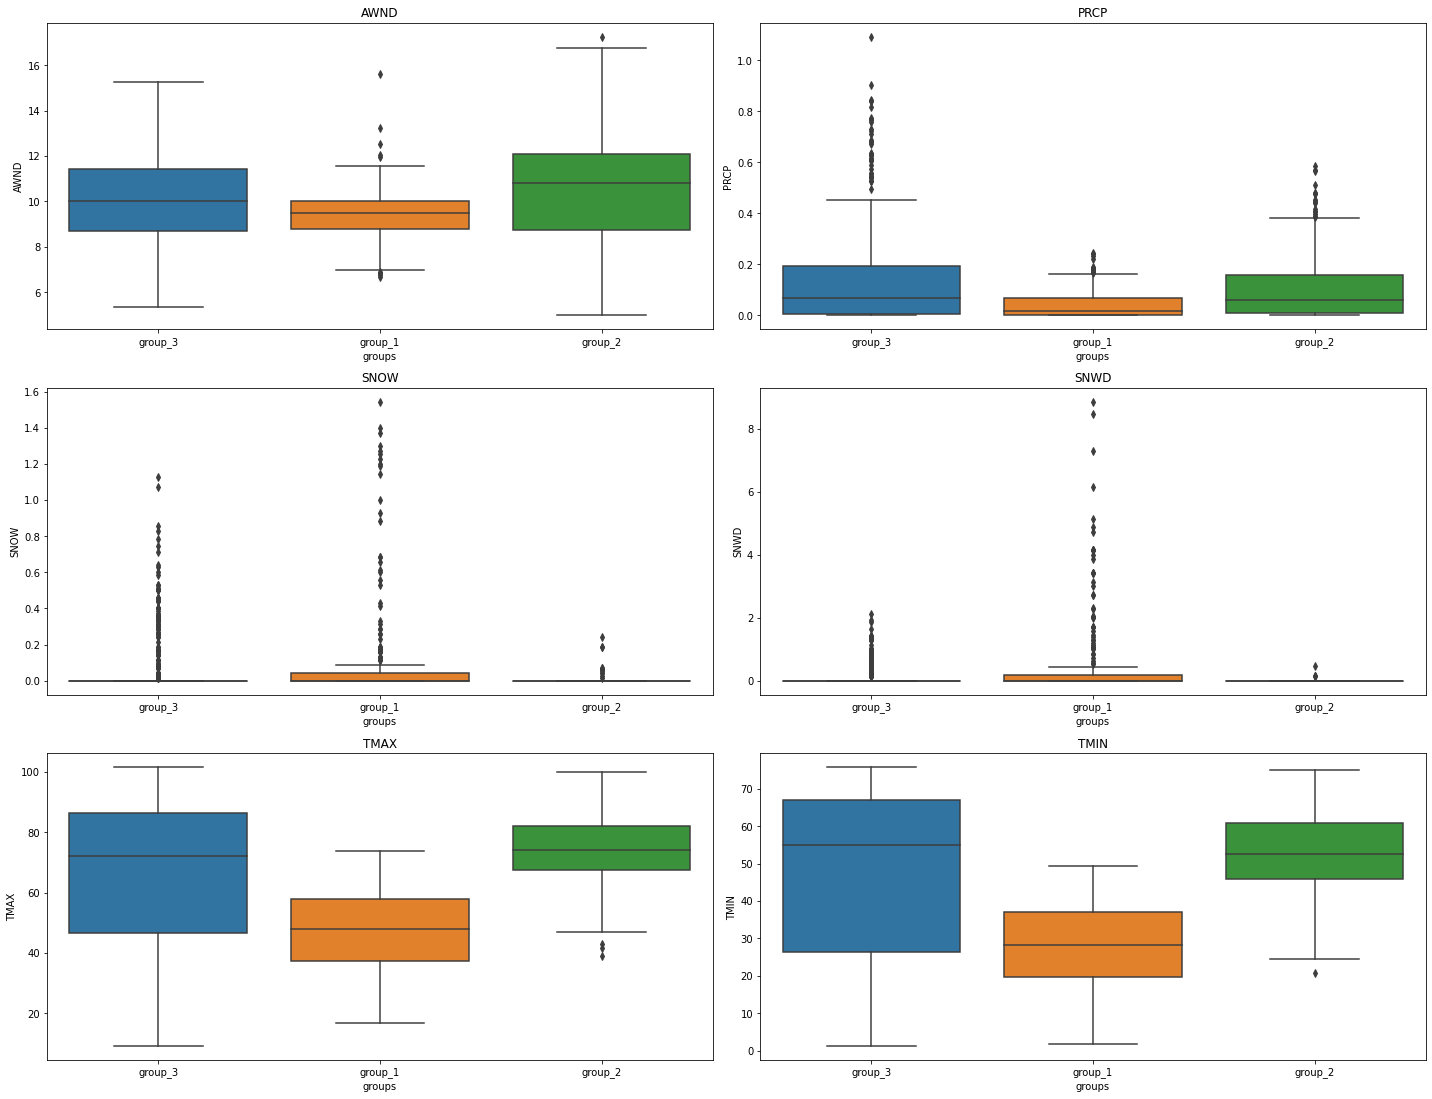

In [47]:
all_col = data.columns.tolist()
plt.figure(figsize=(20, 20))

for i, variable in enumerate(all_col):
    if i==6:
        break
    plt.subplot(4, 2, i + 1)
    #Create boxplot with groups on the x-axis
    sns.boxplot(y=data[variable], x=data['groups'])
    plt.tight_layout()
    plt.title(variable)
plt.show()